In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [4]:
# Read Excel file and save as DataFrame

df = pd.read_excel('./Datasets/tobacco_data.xlsx')
df.columns = df.iloc[0]
df = df[1:]
df.head()

,Intervention_descriptor,tax_increase,outlet_reduction,dec_smoking_prevalence,dec_tobacco_supply,dec_smoking_uptake,age,gender,ethnicity,discount_rate,evidence_strength,qalys_pc,hs_costs_pc
1,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,0-14,Male,non-Māori,0,NaN,40.865526,-1284765.096725
2,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,15-24,Male,non-Māori,0,NaN,41.708939,-1270055.987675
3,Combined tobacco endgame strategy (tobacco-fre...,10,90,7,0,0,25-44,Male,non-Māori,0,NaN,13.282615,-318700.524314
4,Combined tobacco endgame strategy (tobacco-fre...,10,90,1,0,0,45-64,Male,non-Māori,0,NaN,7.222291,-119003.652181
5,Combined tobacco endgame strategy (tobacco-fre...,10,90,0.5,0,0,65+,Male,non-Māori,0,NaN,1.111505,-9656.694651


In [33]:
# Transform data

# Map age group to integer
avg_age_mapping = {
    '0-14': 7,
    '15-24': 20,
    '25-44': 33,
    '45-64': 55,
    '65+': 75
}

# Map gender to integer
gender_mapping = {
    'Male': 0,
    'Female': 1
}

# Map ethnicity to integer
ethnicity_mapping = {
    'Māori': 0,
    'non-Māori': 1
}

# Apply the mapping to the 'Age_Group' column
df['average_age'] = df['age'].map(avg_age_mapping)
df['gender_idx'] = df['gender'].map(gender_mapping)
df['ethnicity_idx'] = df['ethnicity'].map(ethnicity_mapping)

# Convert the specified columns to floats
df[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
    'dec_tobacco_supply', 'dec_smoking_uptake']] = df[['tax_increase', 'outlet_reduction', 
    'dec_smoking_prevalence', 'dec_tobacco_supply', 'dec_smoking_uptake']].apply(pd.to_numeric, errors='coerce').astype('float')

# Display the updated DataFrame
df.head()

,Intervention_descriptor,tax_increase,outlet_reduction,dec_smoking_prevalence,dec_tobacco_supply,dec_smoking_uptake,age,gender,ethnicity,discount_rate,evidence_strength,qalys_pc,hs_costs_pc,average_age,gender_idx,ethnicity_idx
1,Combined tobacco endgame strategy (tobacco-fre...,10.596057,90.370562,7.027669,0.664967,0.989254,0-14,Male,non-Māori,0,NaN,40.932169,-1284765.833031,7.0,0.0,1.0
2,Combined tobacco endgame strategy (tobacco-fre...,9.834083,90.111153,7.462146,-0.641887,-1.300250,15-24,Male,non-Māori,0,NaN,40.587607,-1270056.703071,20.0,0.0,1.0
3,Combined tobacco endgame strategy (tobacco-fre...,10.777226,90.271732,6.782867,1.788515,-0.504437,25-44,Male,non-Māori,0,NaN,13.43444,-318701.146649,33.0,0.0,1.0
4,Combined tobacco endgame strategy (tobacco-fre...,11.827636,89.418375,1.595742,0.057303,-0.665948,45-64,Male,non-Māori,0,NaN,7.792899,-119003.573777,55.0,0.0,1.0
5,Combined tobacco endgame strategy (tobacco-fre...,9.719016,89.864364,0.043169,-0.967009,-0.305661,65+,Male,non-Māori,0,NaN,-0.893392,-9656.074179,75.0,0.0,1.0


In [34]:
# Define Mean Absolute Percentage Error

def mape(y_actual, y_predicted):
    # Convert inputs to numpy arrays for element-wise operations
    y_actual = np.array(y_actual)
    y_predicted = np.array(y_predicted)
    
    # Ensure y_actual and y_predicted have the same length
    assert len(y_actual) == len(y_predicted)
    
    # Avoid division by zero by excluding zero values in y_actual
    non_zero_indices = y_actual != 0
    
    # Calculate MAPE only on non-zero actual values
    error = np.abs((y_actual[non_zero_indices] - y_predicted[non_zero_indices]) / y_actual[non_zero_indices])
    
    # Return the mean error
    return np.mean(error)

In [35]:
# Code to generate Random Forest Model

def generate_rf_model(data, bootstrap):
    # Define dependent and independent variables
    X = np.array(data[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                            'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
                            'gender_idx', 'ethnicity_idx']])

    y = np.array(data[['qalys_pc', 'hs_costs_pc']])

    # Split the dataset
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # List of different values of n_estimators to test
    n_estimators_list = list(range(10, 100, 10))
    max_depths_list = list(range(5, 25, 5))
    
    # 2D Array to store MAPE for different n_estimators and values
    mape_qalys_arr = np.zeros((len(n_estimators_list), len(max_depths_list)))
    mape_costs_arr = np.zeros((len(n_estimators_list), len(max_depths_list)))
    
    # Loop over the values of n_estimators and max_depth
    for i in range(len(n_estimators_list)):
        for j in range(len(max_depths_list)):
            # Initialize the RandomForestRegressor with the current n_estimators and max_depth
            rf1 = RandomForestRegressor(n_estimators=n_estimators_list[i], max_depth=max_depths_list[j], random_state=42, bootstrap=bootstrap)
            rf2 = RandomForestRegressor(n_estimators=n_estimators_list[i], max_depth=max_depths_list[j], random_state=42, bootstrap=bootstrap)
            
            # Train the model on the training data for QALYs and costs
            rf1.fit(X_train, y_train[:, 0])
            rf2.fit(X_train, y_train[:, 1])
                                        
            # Make predictions on the validation set
            y_pred_qaly = rf1.predict(X_val)
            y_pred_cost = rf2.predict(X_val)

            mape_qaly = mape(y_val[:, 0], y_pred_qaly)
            mape_cost = mape(y_val[:, 1], y_pred_cost)
            
            # Store the relative MAPE in the arrays
            mape_qalys_arr[i][j] = mape_qaly
            mape_costs_arr[i][j] = mape_cost

    # Retrieve best hyperparameters
    qaly_min_index = np.unravel_index(np.argmin(mape_qalys_arr), mape_qalys_arr.shape)
    qaly_n_estimators = n_estimators_list[qaly_min_index[0]]
    qaly_max_depth = max_depths_list[qaly_min_index[1]]
    
    hse_min_index = np.unravel_index(np.argmin(mape_costs_arr), mape_costs_arr.shape)
    hse_n_estimators = n_estimators_list[hse_min_index[0]]
    hse_max_depth = max_depths_list[hse_min_index[1]]
    
    # Testing using best n_estimators and max_depth
    rf1_best = RandomForestRegressor(n_estimators=qaly_n_estimators, max_depth=qaly_max_depth, random_state=42, bootstrap=bootstrap)
    rf1_best.fit(X_train, y_train[:,0])
    rf2_best = RandomForestRegressor(n_estimators=hse_n_estimators, max_depth=hse_max_depth, random_state=42, bootstrap=bootstrap)
    rf2_best.fit(X_train, y_train[:,1])
    
    # Make predictions on the test set
    qaly_pred = rf1_best.predict(X_test)
    cost_pred = rf2_best.predict(X_test)
    
    # Compute MAPE for each output
    mape_qaly_test = mape(y_test[:, 0], qaly_pred)
    mape_cost_test = mape(y_test[:, 1], cost_pred)

    # Make predictions on training set
    qaly_pred_train = rf1_best.predict(X_train)
    cost_pred_train = rf2_best.predict(X_train)

    # Compute MAPE for training data
    mape_qaly_train = mape(y_train[:, 0], qaly_pred_train)
    mape_cost_train = mape(y_train[:, 1], cost_pred_train)
    
    print(f'n_estimators for QALYs = {qaly_n_estimators}')
    print(f'max_depth for QALYs = {qaly_max_depth}')
    print(f'MAPE for QALYs: {mape_qaly_test}')
    print("----------------------------------")
    print(f'n_estimators for Health System Cost = {hse_n_estimators}')
    print(f'max_depth for Health System Cost = {hse_max_depth}')
    print(f'MAPE for Health System Cost: {mape_cost_test}')

    return rf1_best, mape_qaly_train, mape_qaly_test, rf2_best, mape_cost_train, mape_cost_test

In [36]:
# Code for generating model where cross validation is used

def generate_rf_model_cv(data, bootstrap):
    # Define dependent and independent variables
    X = np.array(data[['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                       'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
                       'gender_idx', 'ethnicity_idx']])

    y = np.array(data[['qalys_pc', 'hs_costs_pc']])

    # List of different values of n_estimators and max_depth to test
    n_estimators_list = list(range(10, 100, 10))
    max_depths_list = list(range(5, 25, 5))
    
    # 2D Array to store MAPE for different n_estimators and values
    mape_qalys_arr = np.zeros((len(n_estimators_list), len(max_depths_list)))
    mape_costs_arr = np.zeros((len(n_estimators_list), len(max_depths_list)))

    # KFold cross-validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Loop over the values of n_estimators and max_depth
    for i in range(len(n_estimators_list)):
        for j in range(len(max_depths_list)):
            # Initialize the RandomForestRegressor with the current n_estimators and max_depth
            rf1 = RandomForestRegressor(n_estimators=n_estimators_list[i], max_depth=max_depths_list[j], random_state=42, bootstrap=bootstrap)
            rf2 = RandomForestRegressor(n_estimators=n_estimators_list[i], max_depth=max_depths_list[j], random_state=42, bootstrap=bootstrap)

            mape_qaly_fold = []
            mape_cost_fold = []

            # Perform cross-validation
            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                # Train the model on the training data for QALYs and costs
                rf1.fit(X_train, y_train[:, 0])
                rf2.fit(X_train, y_train[:, 1])

                # Make predictions on the validation set
                y_pred_qaly = rf1.predict(X_val)
                y_pred_cost = rf2.predict(X_val)

                mape_qaly_fold.append(mape(y_val[:, 0], y_pred_qaly))
                mape_cost_fold.append(mape(y_val[:, 1], y_pred_cost))

            # Store the average MAPE for the current configuration
            mape_qalys_arr[i][j] = np.mean(mape_qaly_fold)
            mape_costs_arr[i][j] = np.mean(mape_cost_fold)

    # Retrieve best hyperparameters
    qaly_min_index = np.unravel_index(np.argmin(mape_qalys_arr), mape_qalys_arr.shape)
    qaly_n_estimators = n_estimators_list[qaly_min_index[0]]
    qaly_max_depth = max_depths_list[qaly_min_index[1]]
    
    hse_min_index = np.unravel_index(np.argmin(mape_costs_arr), mape_costs_arr.shape)
    hse_n_estimators = n_estimators_list[hse_min_index[0]]
    hse_max_depth = max_depths_list[hse_min_index[1]]
    
    # Training using best n_estimators and max_depth with cross-validation
    rf1_best = RandomForestRegressor(n_estimators=qaly_n_estimators, max_depth=qaly_max_depth, random_state=42, bootstrap=bootstrap)
    rf2_best = RandomForestRegressor(n_estimators=hse_n_estimators, max_depth=hse_max_depth, random_state=42, bootstrap=bootstrap)

    # train_test_split to test best model
    
    # Fit the best models on the entire dataset
    rf1_best.fit(X, y[:, 0])
    rf2_best.fit(X, y[:, 1])

    # Make predictions on the entire dataset for final evaluation
    qaly_pred = rf1_best.predict(X)
    cost_pred = rf2_best.predict(X)

    # Compute MAPE for the entire dataset
    mape_qaly_final = mape(y[:, 0], qaly_pred)
    mape_cost_final = mape(y[:, 1], cost_pred)

    print(f'n_estimators for QALYs = {qaly_n_estimators}')
    print(f'max_depth for QALYs = {qaly_max_depth}')
    print(f'MAPE for QALYs: {mape_qaly_final}')
    print("----------------------------------")
    print(f'n_estimators for Health System Cost = {hse_n_estimators}')
    print(f'max_depth for Health System Cost = {hse_max_depth}')
    print(f'MAPE for Health System Cost: {mape_cost_final}')

    return rf1_best, mape_qaly_final, rf2_best, mape_cost_final

In [37]:
def test_duplicates_rf(n_duplicated, bootstrap, cross_validation):
    np.random.seed(42)
    numeric_columns = ['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                       'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 'qalys_pc', 'hs_costs_pc']

    # Initialise lists
    rf_qaly_ls = []
    mape_qaly_test_ls = []
    rf_cost_ls = []
    mape_cost_test_ls = []

    # Test MAPE for model with train_test_split
    if not cross_validation: # MAPE values for training set needed if cross-validation is not used
        mape_qaly_train_ls = []
        mape_cost_train_ls = []
    
    for i in range(len(n_duplicated)):
        # Duplicate the DataFrame
        df_duplicated = pd.concat([df]*n_duplicated[i], ignore_index=True)
    
        # Add Gaussian noise to the numeric columns with a standard deviation of 0.1
        for col in numeric_columns:
            df_duplicated[col] += np.random.normal(0, 0.1, df_duplicated[col].shape)
        print(f'Dataset with {n_duplicated[i]} duplicates:')

        # Calculate MAPE for cases where cross validation is used and not used
        if not cross_validation:
            rf_qaly, mape_qaly_train, mape_qaly_test, rf_cost, mape_cost_train, mape_cost_test = generate_rf_model(df_duplicated, bootstrap=bootstrap)
            rf_qaly_ls.append(rf_qaly)
            mape_qaly_train_ls.append(mape_qaly_train)
            mape_qaly_test_ls.append(mape_qaly_test)
            rf_cost_ls.append(rf_cost)
            mape_cost_train_ls.append(mape_cost_train)
            mape_cost_test_ls.append(mape_cost_test)
            print("")
        else:
            rf_qaly, mape_qaly_test, rf_cost, mape_cost_test = generate_rf_model_cv(df_duplicated, bootstrap=bootstrap)
            rf_qaly_ls.append(rf_qaly)
            mape_qaly_test_ls.append(mape_qaly_test)
            rf_cost_ls.append(rf_cost)
            mape_cost_test_ls.append(mape_cost_test)
            print("")
            
            
    if not cross_validation:
        # Plot Results
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        # Plot the first subplot (QALY MAPE)
        axes[0].plot(n_duplicated, mape_qaly_train_ls, label='Training Data', color='b', linewidth=2)
        axes[0].plot(n_duplicated, mape_qaly_test_ls, label='Testing Data', color='r', linewidth=2)
        
        # Add labels and title for the first subplot
        axes[0].set_xlabel('Number of Duplicates in Dataset')
        axes[0].set_ylabel('MAPE')
        if bootstrap:
            axes[0].set_title('QALY MAPE with Bootstrapping and train_test_split')
        else:
            axes[0].set_title('QALY MAPE with Resampling Without Replacement and train_test_split')
        axes[0].legend()
        axes[0].grid()
        
        # Plot the second subplot (Health System Costs MAPE)
        axes[1].plot(n_duplicated, mape_cost_train_ls, label='Training Data', color='b', linewidth=2)
        axes[1].plot(n_duplicated, mape_cost_test_ls, label='Testing Data', color='r', linewidth=2)
        
        # Add labels and title for the second subplot
        axes[1].set_xlabel('Number of Duplicates in Dataset')
        axes[1].set_ylabel('MAPE')
        if bootstrap:
            axes[1].set_title('HSC MAPE with Bootstrapping and train_test_split')
        else:
            axes[1].set_title('HSC MAPE with Resampling Without Replacement and train_test_split')
        axes[1].legend()
        axes[1].grid()
        
        # Adjust layout to prevent overlap
        plt.tight_layout()
        
        # Show the plot
        plt.show()
        return rf_qaly_ls, mape_qaly_train_ls, mape_qaly_test_ls, rf_cost_ls, mape_cost_train_ls, mape_cost_test_ls

    # If cross_validation is used
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        # Plot the first subplot (QALY MAPE)
        axes[0].plot(n_duplicated, mape_qaly_test_ls, label='Testing Data', color='r', linewidth=2)
        
        # Add labels and title for the first subplot
        axes[0].set_xlabel('Number of Duplicates in Dataset')
        axes[0].set_ylabel('MAPE')
        if bootstrap:
            axes[0].set_title('QALY MAPE with Bootstrapping and Cross Validation')
        else:
            axes[0].set_title('QALY MAPE with Resampling Without Replacement and Cross Validation')
        axes[0].legend()
        axes[0].grid()
        
        # Plot the second subplot (Health System Costs MAPE)
        axes[1].plot(n_duplicated, mape_cost_test_ls, label='Testing Data', color='r', linewidth=2)
        
        # Add labels and title for the second subplot
        axes[1].set_xlabel('Number of Duplicates in Dataset')
        axes[1].set_ylabel('MAPE')
        if bootstrap:
            axes[1].set_title('HSC MAPE with Bootstrapping and Cross Validation')
        else:
            axes[1].set_title('HSC MAPE with Resampling Without Replacement and Cross Validation')
        axes[1].legend()
        axes[1].grid()
        
        # Adjust layout to prevent overlap
        plt.tight_layout()
        
        # Show the plot
        plt.show()
        return rf_qaly_ls, mape_qaly_test_ls, rf_cost_ls, mape_cost_test_ls

In [38]:
# Number of dataset duplicates to test

n_duplicated = [1, 3, 5, 8, 10]

Dataset with 1 duplicates:
n_estimators for QALYs = 10
max_depth for QALYs = 5
MAPE for QALYs: 1.4562981676312468
----------------------------------
n_estimators for Health System Cost = 10
max_depth for Health System Cost = 15
MAPE for Health System Cost: 0.6923704743384441

Dataset with 3 duplicates:
n_estimators for QALYs = 10
max_depth for QALYs = 10
MAPE for QALYs: 1.339270939902316
----------------------------------
n_estimators for Health System Cost = 10
max_depth for Health System Cost = 10
MAPE for Health System Cost: 3.923931684420068

Dataset with 5 duplicates:
n_estimators for QALYs = 30
max_depth for QALYs = 15
MAPE for QALYs: 0.5922627779707079
----------------------------------
n_estimators for Health System Cost = 10
max_depth for Health System Cost = 15
MAPE for Health System Cost: 3.4629137952130264

Dataset with 8 duplicates:
n_estimators for QALYs = 20
max_depth for QALYs = 15
MAPE for QALYs: 0.12182441907654615
----------------------------------
n_estimators for H

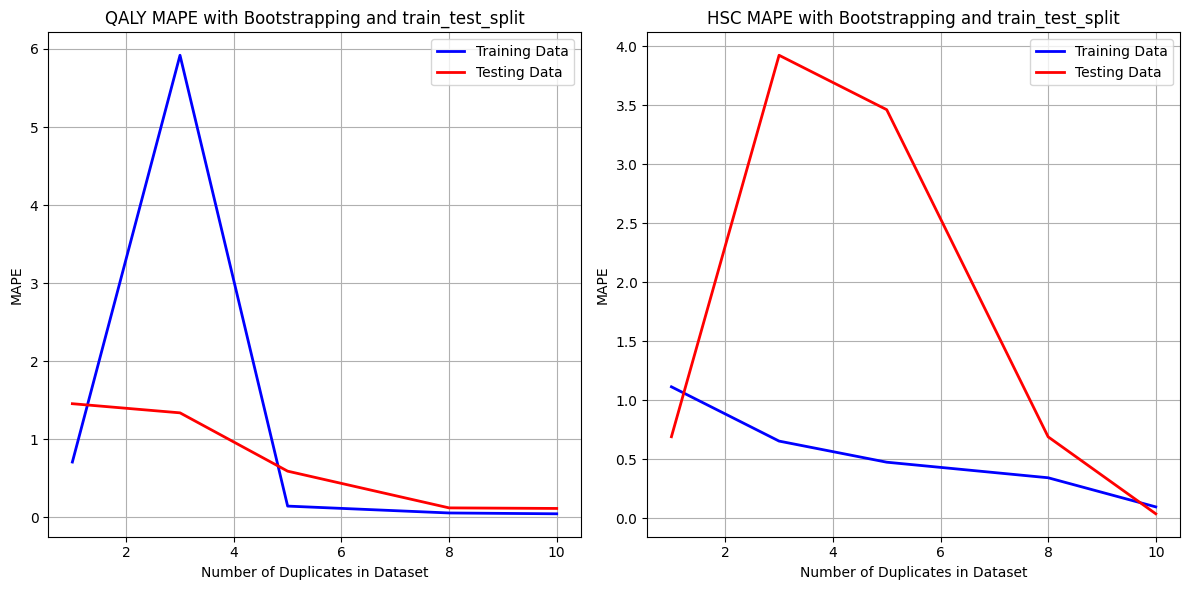

In [39]:
# Results of using Bootstrapping and no Cross-Validation

rf_qaly_bs_nocv, mape_qaly_train_bs_nocv, mape_qaly_test_bs_nocv, rf_cost_bs_nocv, mape_cost_train_bs_nocv, mape_cost_test_bs_nocv = test_duplicates_rf(n_duplicated, bootstrap=True, cross_validation=False)

Dataset with 1 duplicates:
n_estimators for QALYs = 40
max_depth for QALYs = 15
MAPE for QALYs: 0.666383999140149
----------------------------------
n_estimators for Health System Cost = 20
max_depth for Health System Cost = 15
MAPE for Health System Cost: 2.6322292092568005

Dataset with 3 duplicates:
n_estimators for QALYs = 10
max_depth for QALYs = 10
MAPE for QALYs: 0.13853694877783362
----------------------------------
n_estimators for Health System Cost = 10
max_depth for Health System Cost = 15
MAPE for Health System Cost: 0.21327550585394262

Dataset with 5 duplicates:
n_estimators for QALYs = 50
max_depth for QALYs = 20
MAPE for QALYs: 0.057942431874252805
----------------------------------
n_estimators for Health System Cost = 90
max_depth for Health System Cost = 15
MAPE for Health System Cost: 0.28299152810640826

Dataset with 8 duplicates:
n_estimators for QALYs = 90
max_depth for QALYs = 15
MAPE for QALYs: 0.06160704955972669
----------------------------------
n_estimator

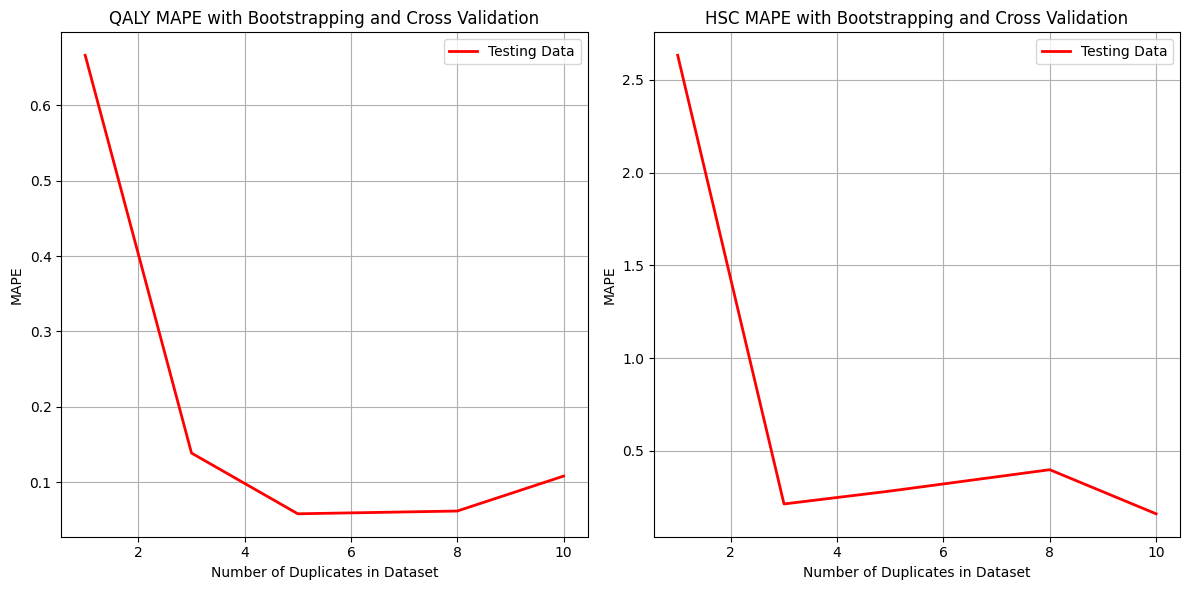

In [40]:
# Results of Bootstrapping with Cross Validation

rf_qaly_bs_cv, mape_qaly_test_bs_cv, rf_cost_bs_cv, mape_cost_test_bs_cv = test_duplicates_rf(n_duplicated, bootstrap=True, cross_validation=True)

Dataset with 1 duplicates:
n_estimators for QALYs = 20
max_depth for QALYs = 15
MAPE for QALYs: 22.184975393194645
----------------------------------
n_estimators for Health System Cost = 20
max_depth for Health System Cost = 15
MAPE for Health System Cost: 0.41988369621891636

Dataset with 3 duplicates:
n_estimators for QALYs = 10
max_depth for QALYs = 10
MAPE for QALYs: 0.15616165190895726
----------------------------------
n_estimators for Health System Cost = 10
max_depth for Health System Cost = 10
MAPE for Health System Cost: 0.04139879957651137

Dataset with 5 duplicates:
n_estimators for QALYs = 20
max_depth for QALYs = 15
MAPE for QALYs: 0.20994334934089412
----------------------------------
n_estimators for Health System Cost = 20
max_depth for Health System Cost = 20
MAPE for Health System Cost: 0.2603160491364829

Dataset with 8 duplicates:
n_estimators for QALYs = 70
max_depth for QALYs = 15
MAPE for QALYs: 0.042152958958404436
----------------------------------
n_estimato

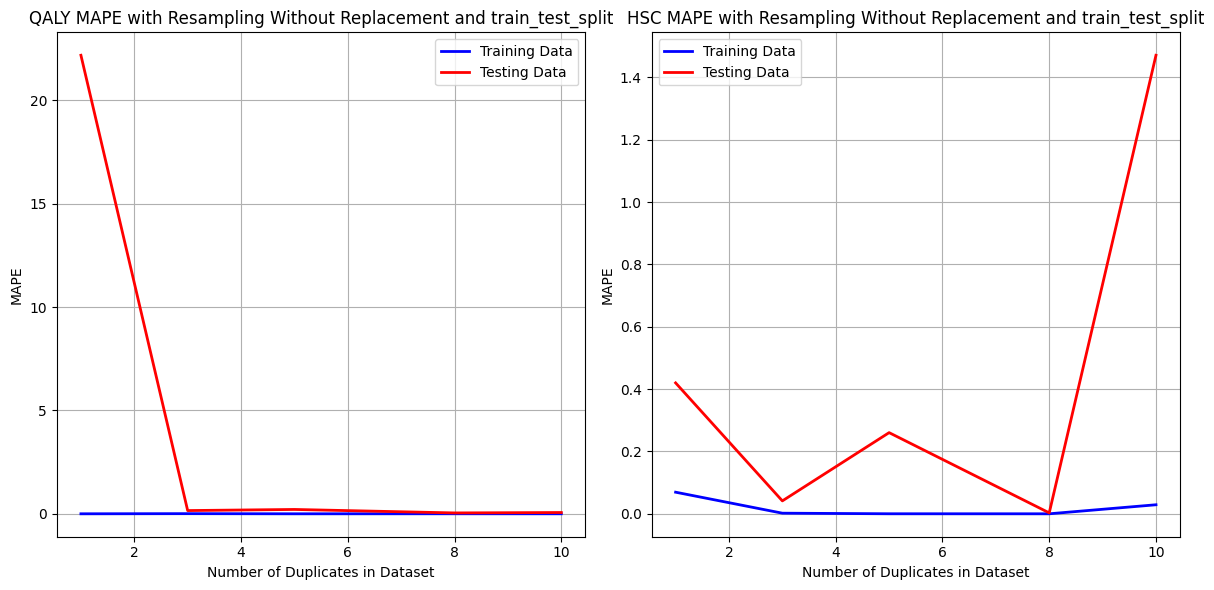

In [41]:
# Results of using Sampling without Replacement and no Cross-Validation

rf_qaly_norep_nocv, mape_qaly_train_norep_nocv, mape_qaly_test_norep_nocv, rf_cost_norep_nocv, mape_cost_train_norep_nocv, mape_cost_test_norep_nocv = test_duplicates_rf(n_duplicated, bootstrap=False, cross_validation=False)

Dataset with 1 duplicates:
n_estimators for QALYs = 40
max_depth for QALYs = 15
MAPE for QALYs: 5.190227650534915e-16
----------------------------------
n_estimators for Health System Cost = 50
max_depth for Health System Cost = 10
MAPE for Health System Cost: 0.14655119722777343

Dataset with 3 duplicates:
n_estimators for QALYs = 90
max_depth for QALYs = 20
MAPE for QALYs: 1.8962538492805037e-05
----------------------------------
n_estimators for Health System Cost = 80
max_depth for Health System Cost = 15
MAPE for Health System Cost: 1.804943492492315e-05

Dataset with 5 duplicates:
n_estimators for QALYs = 20
max_depth for QALYs = 15
MAPE for QALYs: 4.680548308988682e-05
----------------------------------
n_estimators for Health System Cost = 40
max_depth for Health System Cost = 15
MAPE for Health System Cost: 0.00018820398790301033

Dataset with 8 duplicates:
n_estimators for QALYs = 10
max_depth for QALYs = 15
MAPE for QALYs: 0.0007253176321216725
------------------------------

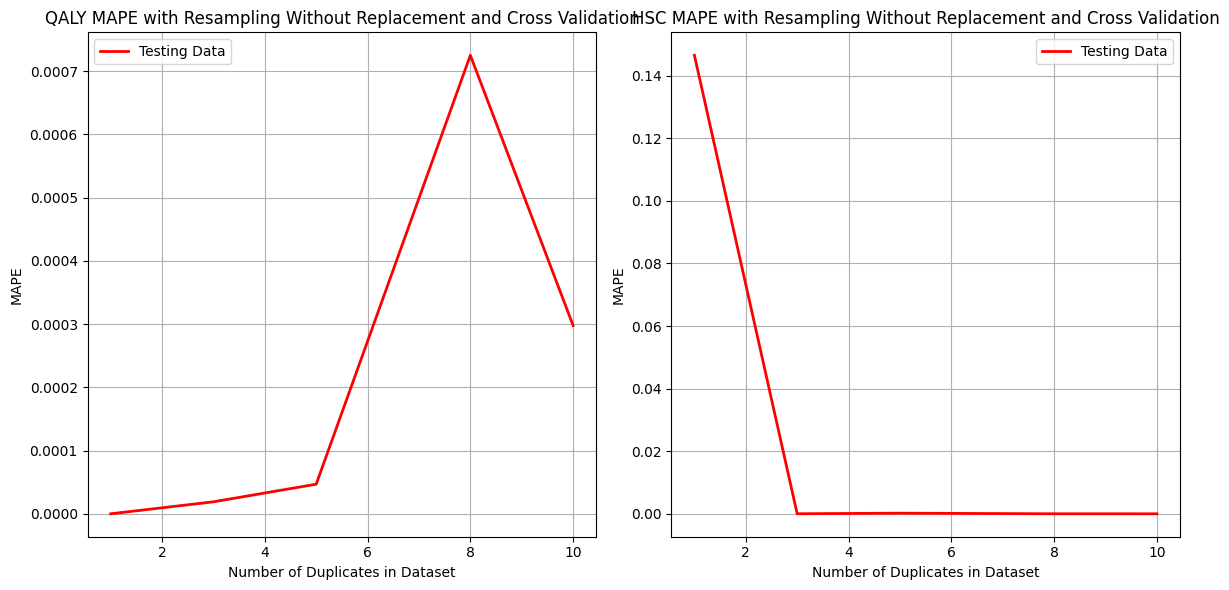

In [42]:
# Results of Sampling without Replacement with Cross Validation

rf_qaly_norep_cv, mape_qaly_test_norep_cv, rf_cost_norep_cv, mape_cost_test_norep_cv = test_duplicates_rf(n_duplicated, bootstrap=False, cross_validation=True)

In [43]:
def display_importance(model):
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': ['tax_increase', 'outlet_reduction', 'dec_smoking_prevalence', 
                                'dec_tobacco_supply', 'dec_smoking_uptake', 'average_age', 
                                'gender_idx', 'ethnicity_idx'],
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    
    # Add labels to the bars
    for bar in bars:
        plt.text(
            bar.get_width() + 0.001, 
            bar.get_y() + bar.get_height()/2,  
            f'{bar.get_width():.4f}', 
            va='center'
        )
    
    # Add labels and title
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance in RandomForestRegressor')
    plt.gca().invert_yaxis()
    
    # Show the plot
    plt.show()

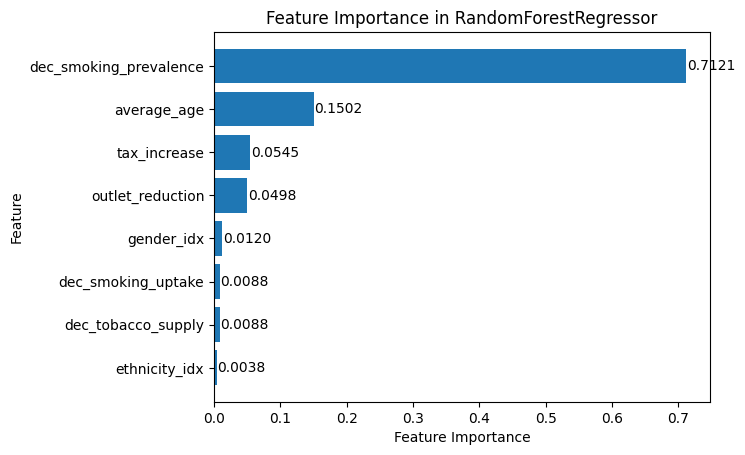

In [46]:
display_importance(rf_qaly_norep_nocv[2])

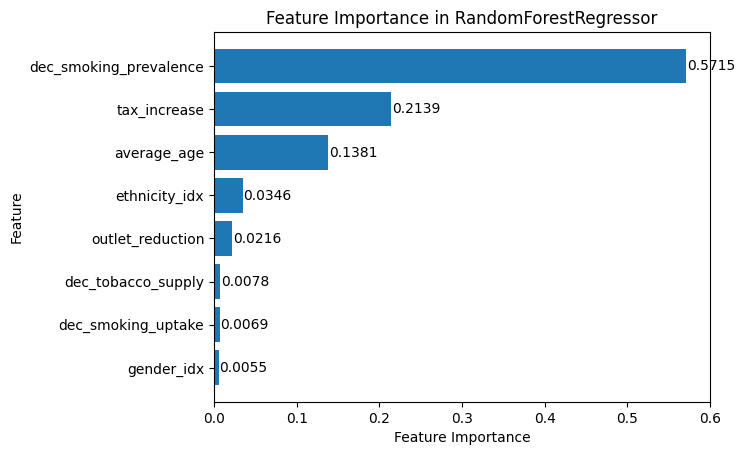

In [47]:
display_importance(rf_cost_norep_nocv[2])